In [ ]:
!pip install yfinance --quiet
import yfinance as yf

import pandas as pd

In [ ]:
reli=yf.Ticker("AXISBANK.NS").history('10y')
reli.to_csv('reli.csv')

In [ ]:
df = pd.read_csv('reli.csv')
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2012-02-15,213.286916,229.722341,212.932070,228.041443,17640965,0.0,0.0
1,2012-02-16,225.081203,230.656173,223.185528,228.657776,12640000,0.0,0.0
2,2012-02-17,233.084141,241.862144,231.590006,238.724472,14647050,0.0,0.0
3,2012-02-21,237.006220,244.374143,236.847470,240.480057,10165915,0.0,0.0
4,2012-02-22,240.237266,241.563289,224.866408,227.116943,15713830,0.0,0.0
...,...,...,...,...,...,...,...,...
2460,2022-02-09,801.000000,809.500000,800.150024,803.849976,9399830,0.0,0.0
2461,2022-02-10,807.549988,815.950012,803.099976,809.799988,12848281,0.0,0.0
2462,2022-02-11,800.950012,809.900024,798.500000,803.799988,9717894,0.0,0.0
2463,2022-02-14,790.000000,803.000000,769.950012,773.349976,8617389,0.0,0.0


In [ ]:
df1=df.reset_index()['Close']
df1

0       228.041443
1       228.657776
2       238.724472
3       240.480057
4       227.116943
           ...    
2460    803.849976
2461    809.799988
2462    803.799988
2463    773.349976
2464    796.950012
Name: Close, Length: 2465, dtype: float64

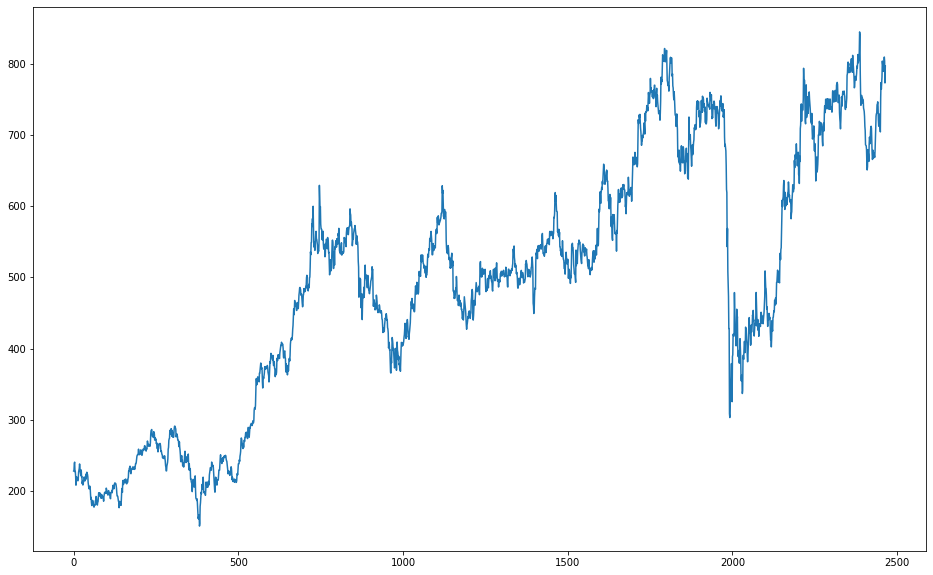

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(df1)

In [ ]:
import numpy as np
df1

0       228.041443
1       228.657776
2       238.724472
3       240.480057
4       227.116943
           ...    
2460    803.849976
2461    809.799988
2462    803.799988
2463    773.349976
2464    796.950012
Name: Close, Length: 2465, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.11147161]
 [0.1123591 ]
 [0.12685455]
 ...
 [0.94053042]
 [0.89668417]
 [0.93066685]]


In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

print(len(train_data))
print(len(test_data))

1602
863


In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 200
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(1401, 200)
(1401,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(662, 200)
(662,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(None,1)))
model.add(LSTM(50,return_sequences=True))   
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, None, 50)          10400     
                                                                 
 lstm_19 (LSTM)              (None, None, 50)          20200     
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=5,batch_size=64,verbose=1)

Epoch 1/5
22/22 [==============================] - 25s 895ms/step - loss: 0.0365 - val_loss: 0.0114
Epoch 2/5
22/22 [==============================] - 16s 723ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 3/5
22/22 [==============================] - 9s 421ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 4/5
22/22 [==============================] - 8s 382ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 5/5
22/22 [==============================] - 9s 390ms/step - loss: 0.0012 - val_loss: 0.0052


In [ ]:
import tensorflow as tf
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

448.9916450286201

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

652.6335452320997

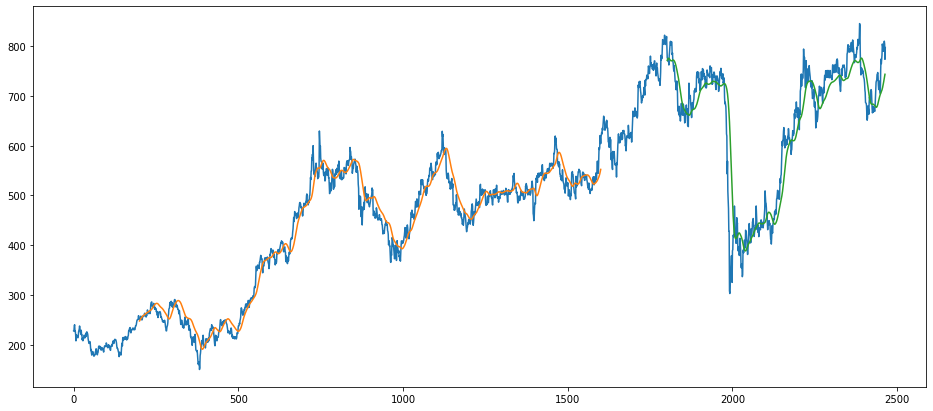

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=200
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(16,7))
ax.plot(scaler.inverse_transform(df1))
ax.plot(trainPredictPlot)
ax.plot(testPredictPlot)
plt.show()

In [ ]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 522)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
#temp_input
# temp_input[:100]
len(temp_input)

522

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=522 
i=1
while(i<30):
    
    if(len(temp_input)>522):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
       #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, -1,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #t(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(np.array(lst_output).shape)

(29, 1)


In [ ]:
x_input = x_input[0]
x_input.shape

(522, 1)

In [ ]:
day_new=np.arange(1,523)
day_pred=np.arange(523,523+29)

In [ ]:
len(day_pred)
#len(test_data)
#len(scaler.inverse_transform(lst_output))

29

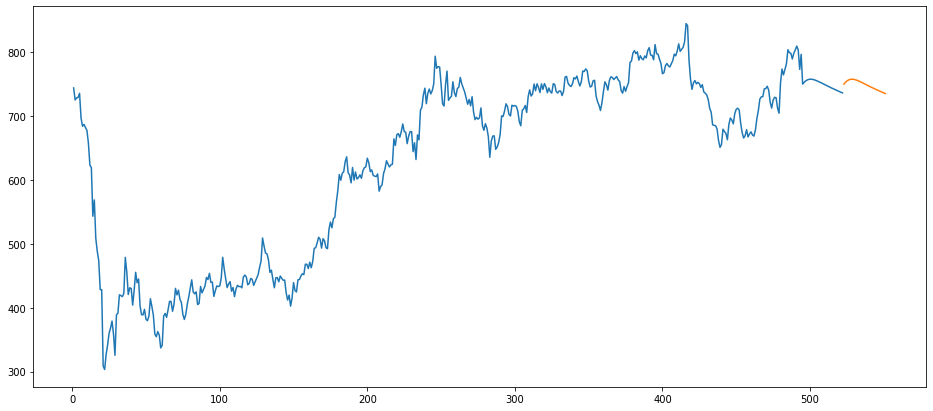

In [ ]:
fig, ax = plt.subplots(figsize=(16,7))
ax.plot(day_new,scaler.inverse_transform(x_input))
ax.plot(day_pred,scaler.inverse_transform(lst_output))

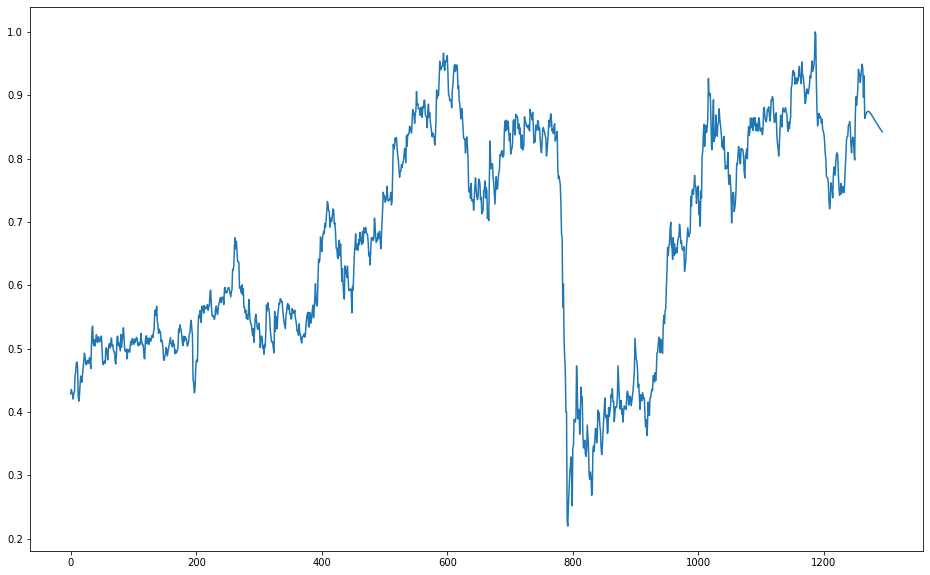

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(df3[1200:])